In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp

/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset1_imgs')
y_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset1_masks')

x_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset2_imgs')
y_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset2_masks')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [13]:
from staintools import StainNormalizer
def stain_normalizer(img, **kwargs):
  normalizer = StainNormalizer(method='macenko')
  normalizer.fit(img)
  return normalizer.transform(img)

def get_training_augmentation():
  train_transform = [
    albu.Lambda(image=stain_normalizer),
#     albu.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=90),
#     albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0),
#     albu.ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=0),
#     albu.Flip(),
#     albu.RandomBrightnessContrast(),
#     albu.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), p=1)
  ]
  return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

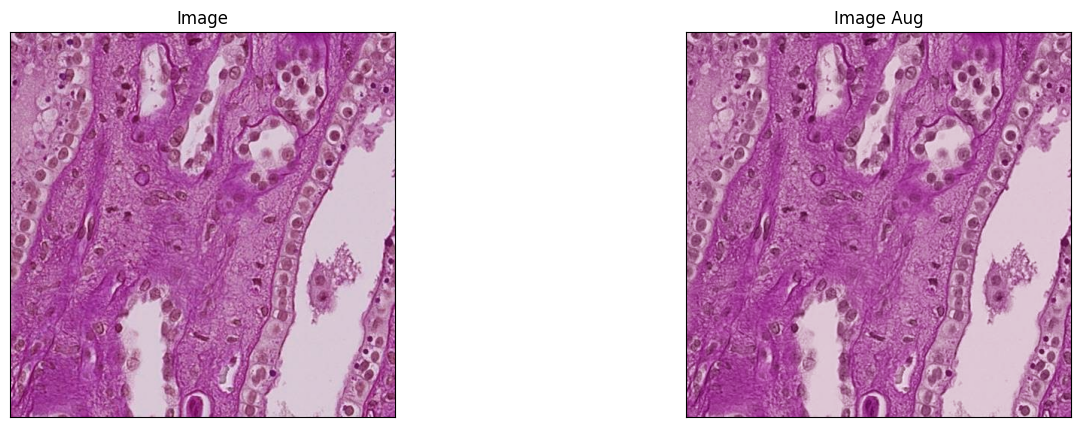

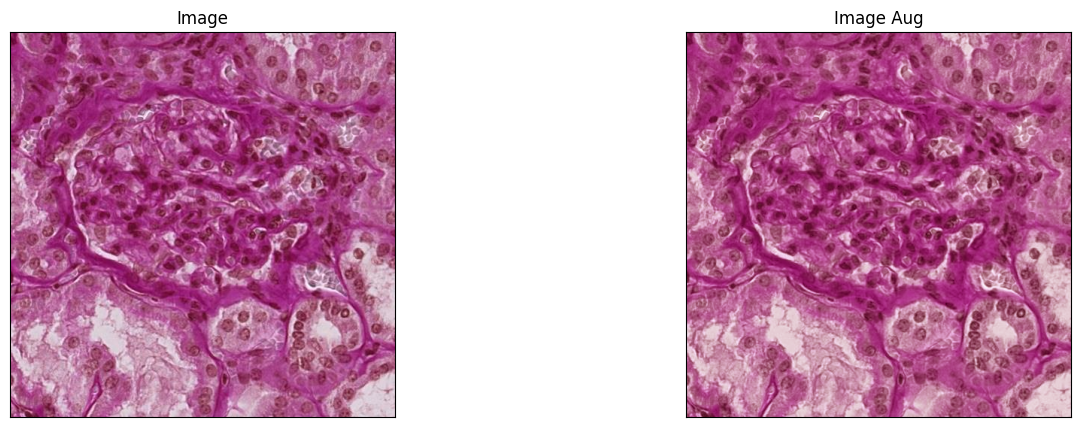

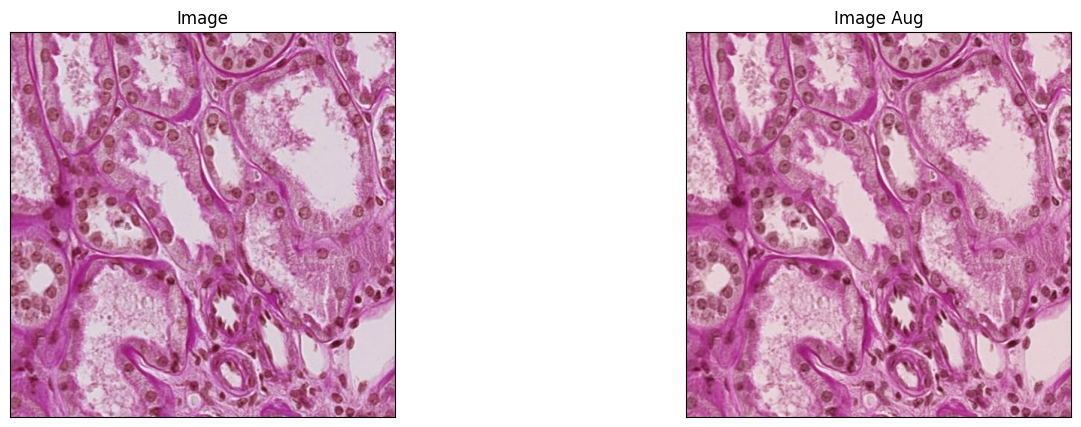

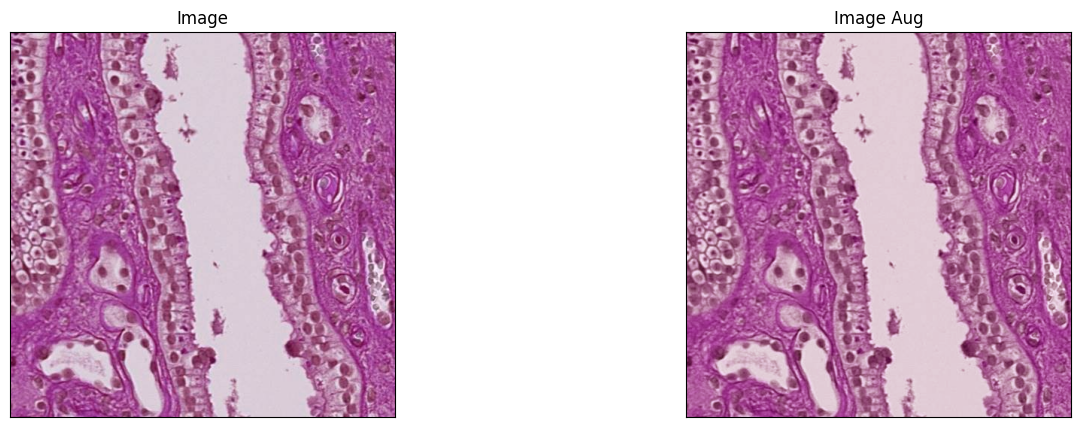

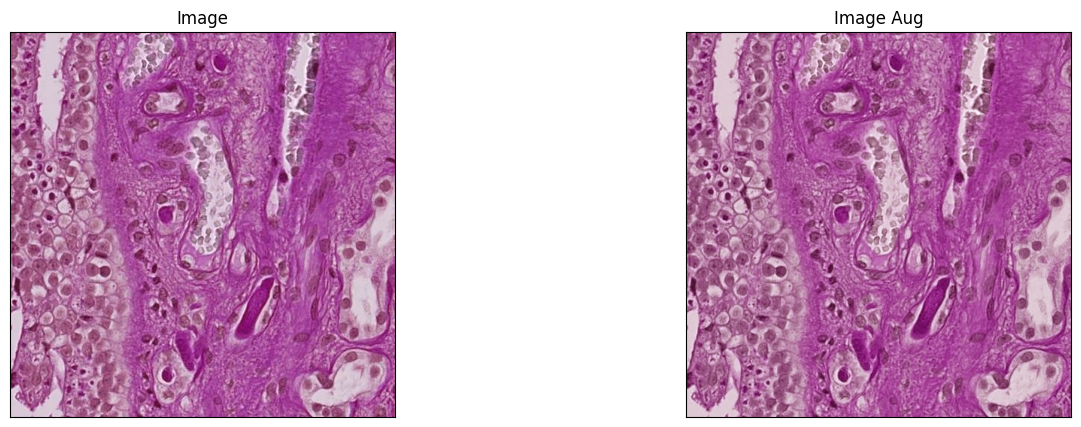

In [14]:
original_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir, 
    classes=['blood_vessel'],
)

augmented_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['blood_vessel'],
)
# same image with different random transforms
for i in range(5):
    image, mask = original_dataset[i]
    image_aug, mask_aug = augmented_dataset[i]
    visualize(image=image, image_aug=image_aug)